In [12]:
# import libraries
import threading
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
import datetime
from concurrent.futures import ThreadPoolExecutor
import sys
from onnxruntime import InferenceSession, SessionOptions, GraphOptimizationLevel
import torch

In [13]:
# import models
from models.tools import wait_process, disp_historicalgraph
from models import signalprocessing as sp
from models import measurement_BNO055
from controller.viewcontrol import measurement_controller

In [14]:
        
def lay(width,height):
    return widgets.Layout(width=str(width)+"px",height=str(height)+"px")
def init_meas_system():
    meas_ctrl = measurement_controller(BNO_UPDATE_FREQUENCY_HZ=10, seq_len=1000, Isautosave=False)
    display(widgets.VBox([
            widgets.HBox([meas_ctrl.ctrl_button, meas_ctrl.save_button, meas_ctrl.calib_button, ]), 
            meas_ctrl.output]))


    return meas_ctrl
def main_loop():
    meas_ctrl = init_meas_system()
    meas_ctrl.Run()
    return meas_ctrl

In [15]:
meas_ctrl = main_loop()

Measurement will be Started...
Measurement is started
Finish
Dataframe was saved!


In [46]:
len(meas_ctrl.measurement.linear_accel_x_queue)

100

In [16]:
meas_ctrl.measurement.bno055_sensor.magnetic

(-28.875, 9.375, -27.5)

In [17]:
meas_ctrl.measurement.magnetic_x_queue[-1]

-27.75

In [47]:
options = SessionOptions()
options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
session = InferenceSession('./data/Prediction_Model_prod_ONNX.onnx',
                           sess_options=options,
                           provider=['CUDAExecutionProvider', 'CPUExecutionProvider'])

In [48]:
while True:
    wait_process(10)
    input = np.concatenate([np.array(meas_ctrl.measurement.linear_accel_x_queue), 
                        np.array(meas_ctrl.measurement.linear_accel_y_queue),
                        np.array(meas_ctrl.measurement.gyro_x_queue),
                        np.array(meas_ctrl.measurement.gyro_y_queue),
                        np.array(meas_ctrl.measurement.gyro_z_queue),
                        np.array(meas_ctrl.measurement.gyro_x_queue)], axis=0).reshape(100,-1)
    input_Tensor = torch.tensor(input, dtype=torch.float32)
    input_Tensor = input_Tensor.reshape(1, 100, -1)
    y = session.run(None, {'input':np.array(input_Tensor.to('cpu'))})
    pred_label = y[0].argmax(1)
    print(pred_label)





[4]
[4]
[4]
[4]
[4]
[4]
[4]
[4]


KeyboardInterrupt: 

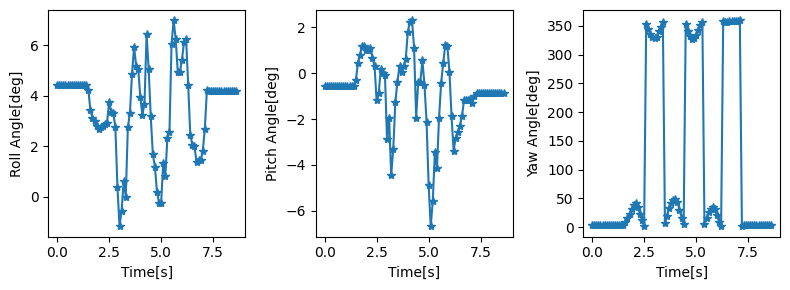

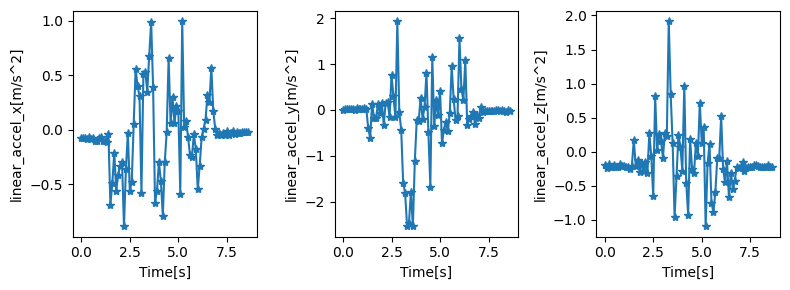

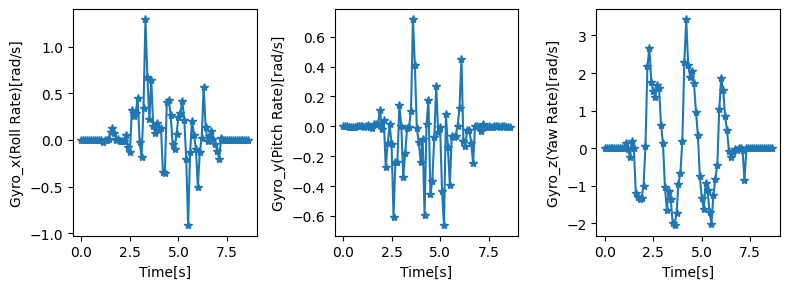

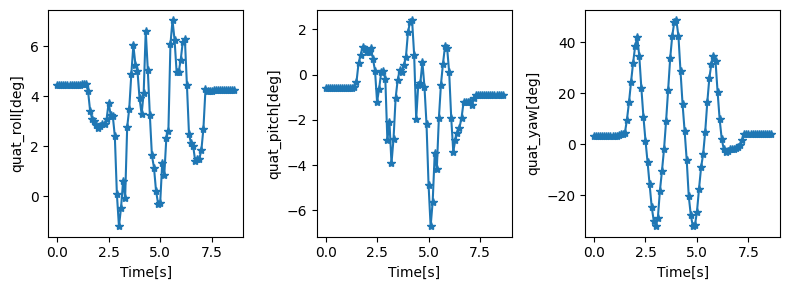

In [7]:
disp_historicalgraph(meas_ctrl.measurement.df, mode="euler")
disp_historicalgraph(meas_ctrl.measurement.df, mode="linear_accel")
disp_historicalgraph(meas_ctrl.measurement.df, mode="gyro")
disp_historicalgraph(meas_ctrl.measurement.df, mode="quat_angle")